# La bibliothèque scipy

Le module scipy comporte les sous-modules importants suivants
* scipy.constants : constantes physiques et mathématiques
* scipy.fft : transformée de Fourier discrète
* scipy.integrate : intégration et équations différentielles
* scipy.interpolate : interpolation
* __scipy.linalg__ : algèbre linéaire
* scipy.optimize : optimisation et recherche de racines
* scipy.signal : traitement du signal
* __scipy.sparse__ : matrices creuses
* scipy.stats : fonctions statistiques

## Matrices creuses

Ce sont des matrices comportant beaucoup de zéros. Plusieurs formats existent pour stocker uniquement que
les termes non nuls.

* csc\_matrix : Compressed Sparse Column
* csr\_matrix : Compressed Sparse Row
* bsr\_matrix : Block Sparse Row
* lil\_matrix : List of Lists
* dok\_matrix : Dictionary of Keys
* coo\_matrix : COOrdinate

L'exemple suivant construit une matrice creuse $3 \times 3$ sous forme __CSC__ avec les éléments non nuls suivants :

In [ ]:
import numpy as np
import scipy.sparse as sp

row  = np.array([0, 2, 2, 0, 1, 2])
col  = np.array([0, 0, 1, 2, 2, 2])
data = np.array([1, 2, 3, 4, 5, 6])

M = sp.csc_matrix((data, (row, col)), shape=(3, 3))
print(M)
print('-'*20)
print(M.todense())

Chaque colonne est stockée séquentiellement avec les valeurs et indices de ligne correspondants.

### Avantages :
* Opérations arithmétiques efficaces : __csc__ + __csc__, __csc__ * __csc__
* Slicing efficace selon les colonnes
* Produit matrice-vecteur rapide

### Inconvénients :
* Accès aux lignes moins efficace qu'en __csr__
* Conversion coûteuse vers d'autres formats

L'exemple suivant transforme une matrice creuse __csc__ en __csr__

In [ ]:
M = sp.csc_matrix((data, (row, col)), shape=(3, 3))
print(type(M))
M = sp.csr_matrix(M) # appel du constructeur
print(type(M))
print(M.getformat()) 
print(M)
print(M.todense())

# Résolution d'une équation laplacienne
On modélise la déformation d'une membrane souple par une équation laplacienne du type :
$$ \frac{\partial^2 u}{\partial x^2} + q(x) =0 $$
où $u$ est le déplacement selon Oz et $q(x)$ la distribution de charges.

On suppose que la membrane est fixée en $x=0$ et $x=L$. Autrement dit, $u(x=0)=0$ et $u(x=L)$.

* En différences finies, en un point __intérieur__ $x$ de la grille, on approxime l'opérateur laplacien appliqué à $u(x)$
par des accroissements.
 
_Indication_ : faire un développement de Taylor de $u(x, y)$ à partir des premiers voisins.
On utilisera le développement limité suivant, pour une fonction à deux variables :
  \begin{equation}
 u(x+\Delta x) = u(x) + \Delta x\; \partial_x u + \frac{1}{2}  (\Delta x)^2\;  \partial^2_x  \; u+
\frac{1}{6}  (\Delta x)^3\;  \partial^3_x  \; u + \vartheta(\Delta x)^4
\end{equation}
Les dérivées partielles étant évaluées en $x$. 
Faire de même avec $u(x-\Delta x)$ et sommer le développement limité avec celui de $u(x+\Delta x)$.

* On montre que l'opérateur laplacien en différences finies s'écrit :
$$\partial^2_x  \; u = \frac{u(x+\Delta x)+u(x-\Delta x)-2u(x)}{\Delta x^2}  + \vartheta(\Delta x)^2$$

* De manière discrète en posant $x = p \times \Delta x$, avec $p \in [0, N-1]$, on a :
  $$\left. \partial^2_x  \; u \right|_p = \frac{u_{p+1}+u_{p-1}-2u_{p}}{\Delta x^2}.$$

* pour les noeuds gauche et droit qui sont __virtuels__, i.e. pour lesquels le déplacement est nul 
  $$\left. \partial^2_x  \; u \right|_0 = \frac{u_{p+1}+0-2u_{p}}{\Delta x^2}.$$
et
  $$\left. \partial^2_x  \; u \right|_L = \frac{0+u_{p-1}-2u_{p}}{\Delta x^2}.$$

In [2]:
import numpy as np
from scipy.sparse import diags

def laplacien_1D_dirichlet(N, h):
    """
    Génère la matrice du Laplacien 1D discrétisé avec conditions de Dirichlet homogènes.
    
    Paramètres : 
    - N : nombre de points internes (sans les bords)
    - h : pas d'espace (distance entre les points)
      o--|--|--|--|--|--|--|--|--o
         0  1  2  3  4  5  6  7 = N-1
    Retourne :
    - L : matrice creuse (sparse) du Laplacien (N x N)
    """
    diagonale = -2 * np.ones(N)
    off_diagonale = np.ones(N - 1)
    data = [off_diagonale, diagonale, off_diagonale]
    offsets = [-1, 0, 1]
    L = diags(data, offsets, format='csr') / h**2
    return L

# Exercice :
Tester cette fonction et afficher la matrice creuse sous une forme matricielle lisible en utilisant la fonction membre
__toarray()__

In [ ]:
N = 9   # nombre de points internes
L = 1.0
h = L / (N + 1)  # on inclut les deux points frontières dans le maillage total

A = laplacien_1D_dirichlet(N, h)
print(A.toarray())
print(type(A))

On suppose que la charge $q$ est uniforme et vaut $-1$, générer le système matricielle puis le résoudre avec une méthode itérative du type gradient conjugué stabilisé.

* Pour ce faire, regarder le manuel du gradient conjugué __scipy.sparse.linalg.cgs__.

In [ ]:
import scipy.sparse as sparse
help(sparse.linalg.cgs)

Temps CPU : 0.000000 secondes
(99,)


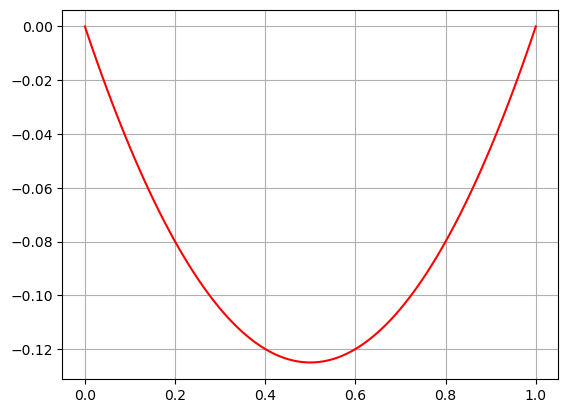

In [11]:
import numpy as np
import matplotlib.pylab as plt
from scipy import optimize
import scipy.sparse as sparse
import time

def solve_sparse(A, b):
    num_iters = 0

    def callback(xk): # exemple d'une fonction privée
        nonlocal num_iters
        num_iters+=1

    M=None # SANS PRECONDITIONNEUR

    x,status=sparse.linalg.cgs(A, b, M=M, rtol=1e-6, callback=callback)
    return x,status,num_iters

N = 99   # nombre de points internes
L = 1.0
h = L / (N + 1)  # on inclut les deux points frontières dans le maillage total

A =  laplacien_1D_dirichlet(N, h)
b =  np.ones(shape=(N, 1))  # terme source
start = time.process_time()
u, status, num_iters = solve_sparse(A, b)
u = np.linalg.solve(A.toarray(), b) # A PROSCRIRE
u = u.reshape(-1)
end = time.process_time()
print(f"Temps CPU : {end - start:.6f} secondes")

print(u.shape)
x = np.linspace(0, 1, N+2)
ut = np.zeros(shape=(N+2))
ut[1:N+1]=u[0:N]  # ATTENTION slicing la borne droite est exclue
plt.plot(x, ut, 'r')
plt.grid()

In [9]:
print(u.reshape(-1))

[-0.00495 -0.0098  -0.01455 -0.0192  -0.02375 -0.0282  -0.03255 -0.0368
 -0.04095 -0.045   -0.04895 -0.0528  -0.05655 -0.0602  -0.06375 -0.0672
 -0.07055 -0.0738  -0.07695 -0.08    -0.08295 -0.0858  -0.08855 -0.0912
 -0.09375 -0.0962  -0.09855 -0.1008  -0.10295 -0.105   -0.10695 -0.1088
 -0.11055 -0.1122  -0.11375 -0.1152  -0.11655 -0.1178  -0.11895 -0.12
 -0.12095 -0.1218  -0.12255 -0.1232  -0.12375 -0.1242  -0.12455 -0.1248
 -0.12495 -0.125   -0.12495 -0.1248  -0.12455 -0.1242  -0.12375 -0.1232
 -0.12255 -0.1218  -0.12095 -0.12    -0.11895 -0.1178  -0.11655 -0.1152
 -0.11375 -0.1122  -0.11055 -0.1088  -0.10695 -0.105   -0.10295 -0.1008
 -0.09855 -0.0962  -0.09375 -0.0912  -0.08855 -0.0858  -0.08295 -0.08
 -0.07695 -0.0738  -0.07055 -0.0672  -0.06375 -0.0602  -0.05655 -0.0528
 -0.04895 -0.045   -0.04095 -0.0368  -0.03255 -0.0282  -0.02375 -0.0192
 -0.01455 -0.0098  -0.00495]


### avec préconditionnement
Un préconditionneur est une matrice permettant d'améliorer le conditionnement de la matrice du système linéaire et en pratique, cela permet d'optimiser le temps de calcul sur de grands systèmes. Curieusement, scipy ne propose pas de préconditionneur du type choleski adapté à notre problème mais un de type factorisation LU incomplète plus général.

<class 'scipy.sparse._csr.csr_matrix'>
Temps CPU : 0.000000 secondes
(99,)
shared memory :  False


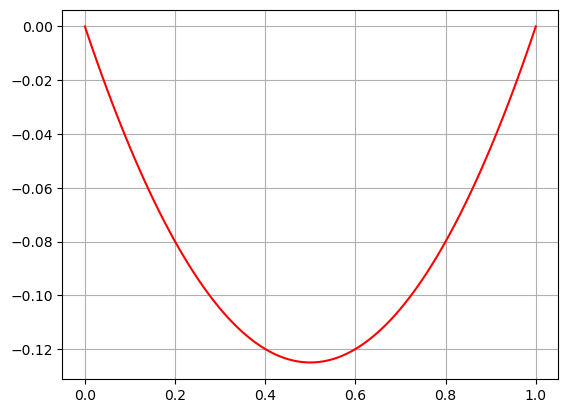

In [3]:
import numpy as np
import matplotlib.pylab as plt
from scipy import optimize
import scipy.sparse as sparse
import time

def solve_sparse(A, b):
    num_iters = 0

    def callback(xk):
        nonlocal num_iters
        num_iters+=1

    A=A.tocsc() # spilu impose que A soit stockee format CSC
    ILU=sparse.linalg.spilu(A) 
    M = sparse.linalg.LinearOperator(shape=(N, N), matvec=ILU.solve)

    x,status=sparse.linalg.cg(A, b, M=M, rtol=1e-6, callback=callback)
    return x,status,num_iters

N = 99   # nombre de points internes
L = 1.0
h = L / (N + 1)  # on inclut les deux points frontières dans le maillage total

A =  laplacien_1D_dirichlet(N, h)
print(type(A))
b =  np.ones(shape=(N, 1))

start = time.process_time()
u, status, num_iters = solve_sparse(A, b)
end = time.process_time()
print(f"Temps CPU : {end - start:.6f} secondes")

print(u.shape)
x = np.linspace(0, 1, N+2)
ut = np.zeros(shape=(N+2))
ut[1:N+1]=u[0:N]  # ATTENTION slicing : la borne droite est exclue
plt.plot(x, ut, 'r')
plt.grid()
print('shared memory : ', np.shares_memory(u, ut))